In [1]:
from pyotf.otf import HanserPSF, apply_aberration, apply_named_aberration
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams['figure.figsize'] = [5, 5]

from data.visualise import show_psf_axial, grid_psfs
from data.align_psfs import  norm_zero_one


kwargs = dict(
    wl=647,
    na=1.3,
    ni=1.51,
    res=106,
    zres=50,
    size=32,
    zsize=40,
    vec_corr="none",
    condition="none",
)
psf = HanserPSF(**kwargs)
psf = apply_aberration(psf, np.array([0, 0, 0, 0, 0]), np.array([0, 0, 0, 0, 1]))

blank_psf = psf.PSFi

blank_psf = norm_zero_one(blank_psf)

print(blank_psf.shape)

(40, 32, 32)


In [2]:
from skimage.transform import resize
n_channels = 3
blank_psf = np.stack([resize(img, (224, 224, n_channels), anti_aliasing=True) for img in blank_psf])


In [3]:
imgs = blank_psf
labels = np.arange(0, imgs.shape[0])

all_imgs = []
all_labels = []
for _ in range(100):
    noise = np.random.uniform(0, 2, size=imgs.shape)
    all_imgs.append(imgs+noise)
    all_labels.append(labels)

all_imgs = np.concatenate(all_imgs)
all_labels = np.concatenate(all_labels)    

In [4]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(all_imgs, all_labels, test_size=0.2, stratify=all_labels)

In [5]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(3200, 224, 224, 3)
(800, 224, 224, 3)
(3200,)
(800,)


In [6]:
import tensorflow as tf
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras import Sequential
from tensorflow.keras.layers import Dense, Dropout

metrics = 'accuracy'
callbacks = [
    ReduceLROnPlateau(
    monitor=metrics, factor=0.1, patience=25, verbose=True,
    mode='min', min_delta=1, min_lr=1e-7,),
    EarlyStopping(monitor=f'val_{metrics}', patience=150, verbose=False, min_delta=1, restore_best_weights=True),
]

n_classes = len(set(labels))
    
resnet = tf.keras.applications.resnet50.ResNet50(
    include_top=False,
    weights=None,
    input_tensor=None,
    input_shape=None,
    pooling='avg',
    classes=n_classes,
    classifier_activation='softmax',
)

model = Sequential([
    resnet,
    Dense(128, activation='ReLU'),
    Dropout(0.5),    
    Dense(n_classes, activation='softmax')
])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss='sparse_categorical_crossentropy', metrics=metrics)

model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=10000, callbacks=callbacks, batch_size=64)

Epoch 1/10000
50/50 [==============================] - 8s 164ms/step - loss: 3.6916 - accuracy: 0.0181 - val_loss: 3.6890 - val_accuracy: 0.0250 - lr: 0.0100
Epoch 11/10000
50/50 [==============================] - 8s 164ms/step - loss: 3.6916 - accuracy: 0.0197 - val_loss: 3.6890 - val_accuracy: 0.0250 - lr: 0.0100
Epoch 12/10000
50/50 [==============================] - 8s 164ms/step - loss: 3.6916 - accuracy: 0.0216 - val_loss: 3.6890 - val_accuracy: 0.0250 - lr: 0.0100
Epoch 13/10000
50/50 [==============================] - 8s 164ms/step - loss: 3.6913 - accuracy: 0.0213 - val_loss: 3.6890 - val_accuracy: 0.0250 - lr: 0.0100
Epoch 14/10000
50/50 [==============================] - 8s 164ms/step - loss: 3.6917 - accuracy: 0.0209 - val_loss: 3.6890 - val_accuracy: 0.0250 - lr: 0.0100
Epoch 15/10000
50/50 [==============================] - 8s 164ms/step - loss: 3.6915 - accuracy: 0.0209 - val_loss: 3.6890 - val_accuracy: 0.0250 - lr: 0.0100
Epoch 16/10000
50/50 [=========================

Epoch 59/10000
50/50 [==============================] - 8s 165ms/step - loss: 3.6889 - accuracy: 0.0250 - val_loss: 3.6889 - val_accuracy: 0.0250 - lr: 1.0000e-04
Epoch 60/10000
50/50 [==============================] - 8s 165ms/step - loss: 3.6889 - accuracy: 0.0250 - val_loss: 3.6889 - val_accuracy: 0.0250 - lr: 1.0000e-04
Epoch 61/10000
50/50 [==============================] - 8s 165ms/step - loss: 3.6889 - accuracy: 0.0250 - val_loss: 3.6889 - val_accuracy: 0.0250 - lr: 1.0000e-04
Epoch 62/10000
50/50 [==============================] - 8s 165ms/step - loss: 3.6889 - accuracy: 0.0250 - val_loss: 3.6889 - val_accuracy: 0.0250 - lr: 1.0000e-04
Epoch 63/10000
50/50 [==============================] - 8s 165ms/step - loss: 3.6889 - accuracy: 0.0250 - val_loss: 3.6889 - val_accuracy: 0.0250 - lr: 1.0000e-04
Epoch 64/10000
50/50 [==============================] - 8s 165ms/step - loss: 3.6889 - accuracy: 0.0250 - val_loss: 3.6889 - val_accuracy: 0.0250 - lr: 1.0000e-04
Epoch 65/10000
50/50 [

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [7]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dense (Dense)               (None, 128)               262272    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 40)                5160      
                                                                 
Total params: 23,855,144
Trainable params: 23,802,024
Non-trainable params: 53,120
_________________________________________________________________
None


(800,)
(800,)
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39}


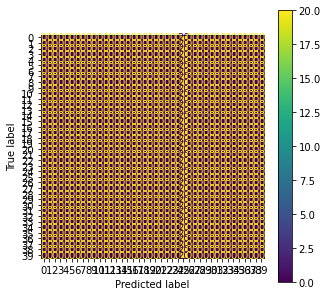

In [8]:
y_pred = model.predict(x_test).argmax(axis=-1)
y_true = y_test

print(y_pred.shape)
print(y_true.shape)
print(set(y_test))
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
cm = ConfusionMatrixDisplay.from_predictions(y_true, y_pred)
